In [1]:
import torch
import torch.nn as nn
import pandas as pd
from transformers import BertTokenizer, BertModel,AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Process started - Using device: {device}")

Process started - Using device: cuda


In [4]:
# Custom Dataset
class MentalHealthDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [5]:
# Load and preprocess data
print("Loading and preprocessing data...")
train_df = pd.read_csv("./dataset/train_dataset.csv")
val_df = pd.read_csv("./dataset/val_dataset.csv")

label_map = {"adhd": 0, "anxiety": 1, "bipolar": 2, "bpd": 3, "depression": 4, "ocd": 5, "ptsd": 6, "none": 7}
train_df["label_id"] = train_df["label"].map(label_map)
val_df["label_id"] = val_df["label"].map(label_map)
label_names = list(label_map.keys())

Loading and preprocessing data...


In [6]:
# Model-specific tokenizers and encodings
print("Tokenizing texts with model-specific tokenizers...")

# BioBERT
biobert_tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2')
biobert_train_encodings = biobert_tokenizer(train_df["processed_text"].tolist(), truncation=True, padding=True, max_length=256)
biobert_val_encodings = biobert_tokenizer(val_df["processed_text"].tolist(), truncation=True, padding=True, max_length=256)

# ClinicalBERT
clinicalbert_tokenizer = AutoTokenizer.from_pretrained('medicalai/ClinicalBERT')
clinicalbert_train_encodings = clinicalbert_tokenizer(train_df["processed_text"].tolist(), truncation=True, padding=True, max_length=256)
clinicalbert_val_encodings = clinicalbert_tokenizer(val_df["processed_text"].tolist(), truncation=True, padding=True, max_length=256)

# MedBERT
medbert_tokenizer = AutoTokenizer.from_pretrained('Charangan/MedBERT')
medbert_train_encodings = medbert_tokenizer(train_df["processed_text"].tolist(), truncation=True, padding=True, max_length=256)
medbert_val_encodings = medbert_tokenizer(val_df["processed_text"].tolist(), truncation=True, padding=True, max_length=256)

# Create datasets for each model
biobert_train_dataset = MentalHealthDataset(biobert_train_encodings, train_df["label_id"].tolist())
biobert_val_dataset = MentalHealthDataset(biobert_val_encodings, val_df["label_id"].tolist())

clinicalbert_train_dataset = MentalHealthDataset(clinicalbert_train_encodings, train_df["label_id"].tolist())
clinicalbert_val_dataset = MentalHealthDataset(clinicalbert_val_encodings, val_df["label_id"].tolist())

medbert_train_dataset = MentalHealthDataset(medbert_train_encodings, train_df["label_id"].tolist())
medbert_val_dataset = MentalHealthDataset(medbert_val_encodings, val_df["label_id"].tolist())

print("Datasets created for all models.")

Tokenizing texts with model-specific tokenizers...


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Datasets created for all models.


In [7]:
# Training function
def train_model(model, train_loader, val_loader, learning_rate, epochs=3):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.5, verbose=True)
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    accumulation_steps = 2

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for step, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask).logits
            loss = criterion(outputs, labels)
            loss.backward()
            if (step + 1) % accumulation_steps == 0:
                optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1} - Avg Train Loss: {avg_train_loss:.4f}")

        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        acc = accuracy_score(val_labels, val_preds)
        print(f"Epoch {epoch+1} - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {acc:.4f}")
        scheduler.step(avg_val_loss)

    duration = (time.time() - start_time) / 60
    return model, duration

In [8]:
# Evaluation function
def evaluate_model(model, val_loader):
    model.eval()
    val_preds, val_labels = [], []
    val_loss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    acc = accuracy_score(val_labels, val_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted')
    return acc, precision, recall, f1, val_preds, val_labels

## Parameter Tuning

In [9]:
# Test configurations
batch_sizes = [8, 16, 32]
learning_rates = [1e-5, 2e-5, 3e-5]

## BioBERT

In [10]:
# BioBERT Training
print("\n=== Training BioBERT Model ===")
biobert_results = []
for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"\nTraining BioBERT - Batch Size: {batch_size}, Learning Rate: {lr}")
        train_loader = DataLoader(biobert_train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(biobert_val_dataset, batch_size=batch_size)
        
        model = AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.2', num_labels=8)
        trained_model, duration = train_model(model, train_loader, val_loader, lr)
        acc, precision, recall, f1, preds, labels = evaluate_model(trained_model, val_loader)
        
        biobert_results.append({
            "Batch Size": batch_size,
            "Learning Rate": lr,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Duration (min)": duration,
            "Preds": preds,
            "Labels": labels
        })


=== Training BioBERT Model ===

Training BioBERT - Batch Size: 8, Learning Rate: 1e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training:   3%|▎         | 78/2658 [00:09<04:31,  9.49it/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch 1/3 - Training: 100%|██████████| 2658/2658 [04:54<00:00,  9.01it/s]


Epoch 1 - Avg Train Loss: 0.9643
Epoch 1 - Val Loss: 0.6820, Val Accuracy: 0.7776


Epoch 2/3 - Training: 100%|██████████| 2658/2658 [04:55<00:00,  8.99it/s]


Epoch 2 - Avg Train Loss: 0.5688
Epoch 2 - Val Loss: 0.6247, Val Accuracy: 0.7910


Epoch 3/3 - Training: 100%|██████████| 2658/2658 [04:55<00:00,  9.00it/s]


Epoch 3 - Avg Train Loss: 0.4618
Epoch 3 - Val Loss: 0.5718, Val Accuracy: 0.8117

Training BioBERT - Batch Size: 8, Learning Rate: 2e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 2658/2658 [04:55<00:00,  9.00it/s]


Epoch 1 - Avg Train Loss: 0.9414
Epoch 1 - Val Loss: 0.6710, Val Accuracy: 0.7828


Epoch 2/3 - Training: 100%|██████████| 2658/2658 [04:55<00:00,  8.99it/s]


Epoch 2 - Avg Train Loss: 0.5868
Epoch 2 - Val Loss: 0.5958, Val Accuracy: 0.8076


Epoch 3/3 - Training: 100%|██████████| 2658/2658 [04:55<00:00,  8.99it/s]


Epoch 3 - Avg Train Loss: 0.4693
Epoch 3 - Val Loss: 0.5904, Val Accuracy: 0.8115

Training BioBERT - Batch Size: 8, Learning Rate: 3e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 2658/2658 [04:55<00:00,  9.00it/s]


Epoch 1 - Avg Train Loss: 0.9403
Epoch 1 - Val Loss: 0.7366, Val Accuracy: 0.7640


Epoch 2/3 - Training: 100%|██████████| 2658/2658 [04:55<00:00,  8.99it/s]


Epoch 2 - Avg Train Loss: 0.6077
Epoch 2 - Val Loss: 0.6064, Val Accuracy: 0.8039


Epoch 3/3 - Training: 100%|██████████| 2658/2658 [04:56<00:00,  8.98it/s]


Epoch 3 - Avg Train Loss: 0.5165
Epoch 3 - Val Loss: 0.6457, Val Accuracy: 0.7927

Training BioBERT - Batch Size: 16, Learning Rate: 1e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 1329/1329 [04:32<00:00,  4.89it/s]


Epoch 1 - Avg Train Loss: 1.1070
Epoch 1 - Val Loss: 0.6723, Val Accuracy: 0.7825


Epoch 2/3 - Training: 100%|██████████| 1329/1329 [04:32<00:00,  4.89it/s]


Epoch 2 - Avg Train Loss: 0.6061
Epoch 2 - Val Loss: 0.5944, Val Accuracy: 0.8076


Epoch 3/3 - Training: 100%|██████████| 1329/1329 [04:32<00:00,  4.88it/s]


Epoch 3 - Avg Train Loss: 0.4942
Epoch 3 - Val Loss: 0.5826, Val Accuracy: 0.8125

Training BioBERT - Batch Size: 16, Learning Rate: 2e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 1329/1329 [04:31<00:00,  4.89it/s]


Epoch 1 - Avg Train Loss: 0.9146
Epoch 1 - Val Loss: 0.6483, Val Accuracy: 0.7890


Epoch 2/3 - Training: 100%|██████████| 1329/1329 [04:31<00:00,  4.89it/s]


Epoch 2 - Avg Train Loss: 0.5559
Epoch 2 - Val Loss: 0.5859, Val Accuracy: 0.8094


Epoch 3/3 - Training: 100%|██████████| 1329/1329 [04:32<00:00,  4.88it/s]


Epoch 3 - Avg Train Loss: 0.4516
Epoch 3 - Val Loss: 0.5646, Val Accuracy: 0.8188

Training BioBERT - Batch Size: 16, Learning Rate: 3e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 1329/1329 [04:31<00:00,  4.89it/s]


Epoch 1 - Avg Train Loss: 0.9121
Epoch 1 - Val Loss: 0.6589, Val Accuracy: 0.7809


Epoch 2/3 - Training: 100%|██████████| 1329/1329 [04:31<00:00,  4.89it/s]


Epoch 2 - Avg Train Loss: 0.5673
Epoch 2 - Val Loss: 0.6212, Val Accuracy: 0.7995


Epoch 3/3 - Training: 100%|██████████| 1329/1329 [04:31<00:00,  4.89it/s]


Epoch 3 - Avg Train Loss: 0.4587
Epoch 3 - Val Loss: 0.5802, Val Accuracy: 0.8130

Training BioBERT - Batch Size: 32, Learning Rate: 1e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.63it/s]


Epoch 1 - Avg Train Loss: 1.2597
Epoch 1 - Val Loss: 0.7252, Val Accuracy: 0.7686


Epoch 2/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.63it/s]


Epoch 2 - Avg Train Loss: 0.6541
Epoch 2 - Val Loss: 0.6368, Val Accuracy: 0.7915


Epoch 3/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.63it/s]


Epoch 3 - Avg Train Loss: 0.5480
Epoch 3 - Val Loss: 0.6056, Val Accuracy: 0.8026

Training BioBERT - Batch Size: 32, Learning Rate: 2e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.63it/s]


Epoch 1 - Avg Train Loss: 1.0402
Epoch 1 - Val Loss: 0.6839, Val Accuracy: 0.7767


Epoch 2/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.64it/s]


Epoch 2 - Avg Train Loss: 0.5770
Epoch 2 - Val Loss: 0.5945, Val Accuracy: 0.8065


Epoch 3/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.63it/s]


Epoch 3 - Avg Train Loss: 0.4715
Epoch 3 - Val Loss: 0.5682, Val Accuracy: 0.8163

Training BioBERT - Batch Size: 32, Learning Rate: 3e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.63it/s]


Epoch 1 - Avg Train Loss: 0.9766
Epoch 1 - Val Loss: 0.6634, Val Accuracy: 0.7784


Epoch 2/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.63it/s]


Epoch 2 - Avg Train Loss: 0.5808
Epoch 2 - Val Loss: 0.5864, Val Accuracy: 0.8059


Epoch 3/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.63it/s]


Epoch 3 - Avg Train Loss: 0.4652
Epoch 3 - Val Loss: 0.5703, Val Accuracy: 0.8128


In [11]:
# BioBERT Results
biobert_df = pd.DataFrame(biobert_results).drop(columns=["Preds", "Labels"])
print("\nBioBERT Results Summary:")
biobert_df


BioBERT Results Summary:


,Batch Size,Learning Rate,Accuracy,Precision,Recall,F1,Duration (min)
0,8,0.00001,0.811698,0.824204,0.811698,0.814577,16.790408
1,8,0.00002,0.811478,0.815889,0.811478,0.811072,16.796301
2,8,0.00003,0.792714,0.806222,0.792714,0.794529,16.803300
3,16,0.00001,0.812466,0.825800,0.812466,0.814096,15.548395
4,16,0.00002,0.818830,0.828712,0.818830,0.820618,15.544125
5,16,0.00003,0.813014,0.822108,0.813014,0.814565,15.542917
6,32,0.00001,0.802590,0.805523,0.802590,0.802012,14.541755
7,32,0.00002,0.816306,0.824373,0.816306,0.817228,14.524847
8,32,0.00003,0.812795,0.823270,0.812795,0.814626,14.522885


In [12]:
# Best BioBERT Configuration
best_biobert_config = biobert_df.loc[biobert_df["F1"].idxmax()]
print(f"\nBest BioBERT Configuration: Batch Size {best_biobert_config['Batch Size']}, Learning Rate {best_biobert_config['Learning Rate']}")
print(f"Accuracy: {best_biobert_config['Accuracy']:.4f}, Precision: {best_biobert_config['Precision']:.4f}, Recall: {best_biobert_config['Recall']:.4f}, F1: {best_biobert_config['F1']:.4f}")


Best BioBERT Configuration: Batch Size 16.0, Learning Rate 2e-05
Accuracy: 0.8188, Precision: 0.8287, Recall: 0.8188, F1: 0.8206


In [13]:
best_biobert_idx = biobert_df["F1"].idxmax()
best_biobert_preds = biobert_results[best_biobert_idx]["Preds"]
best_biobert_labels = biobert_results[best_biobert_idx]["Labels"]

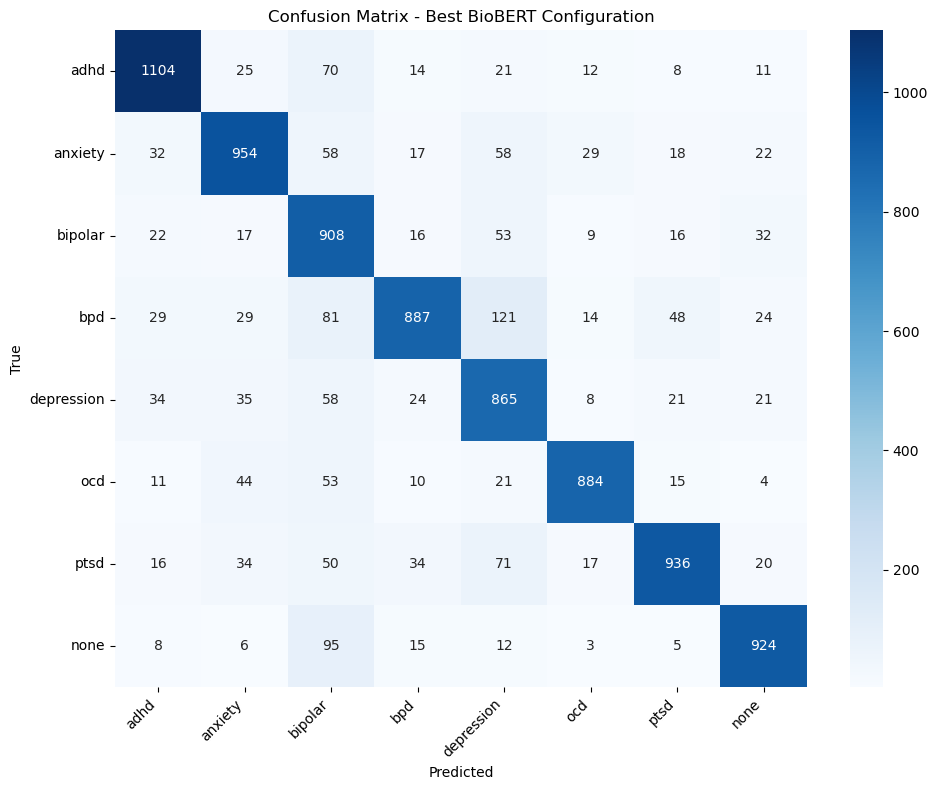

In [14]:
# BioBERT Confusion Matrix
cm_biobert = confusion_matrix(best_biobert_labels, best_biobert_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_biobert, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix - Best BioBERT Configuration")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [15]:
# BioBERT Classification Report
print("\nClassification Report for Best BioBERT Configuration:")
print(classification_report(best_biobert_labels, best_biobert_preds, target_names=label_names, digits=3))


Classification Report for Best BioBERT Configuration:
              precision    recall  f1-score   support

        adhd      0.879     0.873     0.876      1265
     anxiety      0.834     0.803     0.818      1188
     bipolar      0.661     0.846     0.742      1073
         bpd      0.872     0.719     0.788      1233
  depression      0.708     0.811     0.756      1066
         ocd      0.906     0.848     0.876      1042
        ptsd      0.877     0.795     0.834      1178
        none      0.873     0.865     0.869      1068

    accuracy                          0.819      9113
   macro avg      0.826     0.820     0.820      9113
weighted avg      0.829     0.819     0.821      9113



In [16]:
# ClinicalBERT Training
print("\n=== Training ClinicalBERT Model ===")
clinicalbert_results = []
for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"\nTraining ClinicalBERT - Batch Size: {batch_size}, Learning Rate: {lr}")
        train_loader = DataLoader(clinicalbert_train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(clinicalbert_val_dataset, batch_size=batch_size)
        
        model = AutoModelForSequenceClassification.from_pretrained('medicalai/ClinicalBERT', num_labels=8)
        trained_model, duration = train_model(model, train_loader, val_loader, lr)
        acc, precision, recall, f1, preds, labels = evaluate_model(trained_model, val_loader)
        
        clinicalbert_results.append({
            "Batch Size": batch_size,
            "Learning Rate": lr,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Duration (min)": duration,
            "Preds": preds,
            "Labels": labels
        })


=== Training ClinicalBERT Model ===

Training ClinicalBERT - Batch Size: 8, Learning Rate: 1e-05


pytorch_model.bin:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training:   1%|          | 19/2658 [00:01<02:39, 16.55it/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Epoch 1/3 - Training: 100%|██████████| 2658/2658 [02:39<00:00, 16.65it/s]


Epoch 1 - Avg Train Loss: 1.1207
Epoch 1 - Val Loss: 0.7212, Val Accuracy: 0.7687


Epoch 2/3 - Training: 100%|██████████| 2658/2658 [02:40<00:00, 16.61it/s]


Epoch 2 - Avg Train Loss: 0.6575
Epoch 2 - Val Loss: 0.6409, Val Accuracy: 0.7896


Epoch 3/3 - Training: 100%|██████████| 2658/2658 [02:40<00:00, 16.60it/s]


Epoch 3 - Avg Train Loss: 0.5606
Epoch 3 - Val Loss: 0.6308, Val Accuracy: 0.7914

Training ClinicalBERT - Batch Size: 8, Learning Rate: 2e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 2658/2658 [02:40<00:00, 16.59it/s]


Epoch 1 - Avg Train Loss: 0.9764
Epoch 1 - Val Loss: 0.6881, Val Accuracy: 0.7788


Epoch 2/3 - Training: 100%|██████████| 2658/2658 [02:40<00:00, 16.59it/s]


Epoch 2 - Avg Train Loss: 0.6241
Epoch 2 - Val Loss: 0.6349, Val Accuracy: 0.7956


Epoch 3/3 - Training: 100%|██████████| 2658/2658 [02:40<00:00, 16.58it/s]


Epoch 3 - Avg Train Loss: 0.5260
Epoch 3 - Val Loss: 0.6305, Val Accuracy: 0.7961

Training ClinicalBERT - Batch Size: 8, Learning Rate: 3e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 2658/2658 [02:40<00:00, 16.57it/s]


Epoch 1 - Avg Train Loss: 1.1045
Epoch 1 - Val Loss: 0.7434, Val Accuracy: 0.7597


Epoch 2/3 - Training: 100%|██████████| 2658/2658 [02:40<00:00, 16.59it/s]


Epoch 2 - Avg Train Loss: 0.6467
Epoch 2 - Val Loss: 0.6508, Val Accuracy: 0.7899


Epoch 3/3 - Training: 100%|██████████| 2658/2658 [02:40<00:00, 16.59it/s]


Epoch 3 - Avg Train Loss: 0.5365
Epoch 3 - Val Loss: 0.6490, Val Accuracy: 0.7916

Training ClinicalBERT - Batch Size: 16, Learning Rate: 1e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 1329/1329 [02:22<00:00,  9.31it/s]


Epoch 1 - Avg Train Loss: 1.1801
Epoch 1 - Val Loss: 0.7623, Val Accuracy: 0.7532


Epoch 2/3 - Training: 100%|██████████| 1329/1329 [02:22<00:00,  9.31it/s]


Epoch 2 - Avg Train Loss: 0.7014
Epoch 2 - Val Loss: 0.6878, Val Accuracy: 0.7772


Epoch 3/3 - Training: 100%|██████████| 1329/1329 [02:22<00:00,  9.30it/s]


Epoch 3 - Avg Train Loss: 0.6004
Epoch 3 - Val Loss: 0.6689, Val Accuracy: 0.7851

Training ClinicalBERT - Batch Size: 16, Learning Rate: 2e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 1329/1329 [02:22<00:00,  9.31it/s]


Epoch 1 - Avg Train Loss: 1.0894
Epoch 1 - Val Loss: 0.7355, Val Accuracy: 0.7611


Epoch 2/3 - Training: 100%|██████████| 1329/1329 [02:22<00:00,  9.30it/s]


Epoch 2 - Avg Train Loss: 0.6451
Epoch 2 - Val Loss: 0.6754, Val Accuracy: 0.7823


Epoch 3/3 - Training: 100%|██████████| 1329/1329 [02:22<00:00,  9.30it/s]


Epoch 3 - Avg Train Loss: 0.5394
Epoch 3 - Val Loss: 0.6116, Val Accuracy: 0.8002

Training ClinicalBERT - Batch Size: 16, Learning Rate: 3e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 1329/1329 [02:22<00:00,  9.31it/s]


Epoch 1 - Avg Train Loss: 1.0301
Epoch 1 - Val Loss: 0.7106, Val Accuracy: 0.7726


Epoch 2/3 - Training: 100%|██████████| 1329/1329 [02:22<00:00,  9.31it/s]


Epoch 2 - Avg Train Loss: 0.6338
Epoch 2 - Val Loss: 0.6327, Val Accuracy: 0.7950


Epoch 3/3 - Training: 100%|██████████| 1329/1329 [02:22<00:00,  9.31it/s]


Epoch 3 - Avg Train Loss: 0.5217
Epoch 3 - Val Loss: 0.6242, Val Accuracy: 0.8034

Training ClinicalBERT - Batch Size: 32, Learning Rate: 1e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 665/665 [02:10<00:00,  5.10it/s]


Epoch 1 - Avg Train Loss: 1.4056
Epoch 1 - Val Loss: 0.8261, Val Accuracy: 0.7402


Epoch 2/3 - Training: 100%|██████████| 665/665 [02:10<00:00,  5.10it/s]


Epoch 2 - Avg Train Loss: 0.7470
Epoch 2 - Val Loss: 0.6953, Val Accuracy: 0.7756


Epoch 3/3 - Training: 100%|██████████| 665/665 [02:10<00:00,  5.10it/s]


Epoch 3 - Avg Train Loss: 0.6349
Epoch 3 - Val Loss: 0.6530, Val Accuracy: 0.7884

Training ClinicalBERT - Batch Size: 32, Learning Rate: 2e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 665/665 [02:10<00:00,  5.11it/s]


Epoch 1 - Avg Train Loss: 1.1661
Epoch 1 - Val Loss: 0.7506, Val Accuracy: 0.7576


Epoch 2/3 - Training: 100%|██████████| 665/665 [02:10<00:00,  5.11it/s]


Epoch 2 - Avg Train Loss: 0.6823
Epoch 2 - Val Loss: 0.6547, Val Accuracy: 0.7824


Epoch 3/3 - Training: 100%|██████████| 665/665 [02:10<00:00,  5.11it/s]


Epoch 3 - Avg Train Loss: 0.5694
Epoch 3 - Val Loss: 0.6190, Val Accuracy: 0.7980

Training ClinicalBERT - Batch Size: 32, Learning Rate: 3e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 665/665 [02:10<00:00,  5.11it/s]


Epoch 1 - Avg Train Loss: 1.1264
Epoch 1 - Val Loss: 0.7281, Val Accuracy: 0.7669


Epoch 2/3 - Training: 100%|██████████| 665/665 [02:10<00:00,  5.11it/s]


Epoch 2 - Avg Train Loss: 0.6417
Epoch 2 - Val Loss: 0.6222, Val Accuracy: 0.7945


Epoch 3/3 - Training: 100%|██████████| 665/665 [02:10<00:00,  5.11it/s]


Epoch 3 - Avg Train Loss: 0.5331
Epoch 3 - Val Loss: 0.6136, Val Accuracy: 0.8023


In [17]:
# ClinicalBERT Results
clinicalbert_df = pd.DataFrame(clinicalbert_results).drop(columns=["Preds", "Labels"])
print("\nClinicalBERT Results Summary:")
clinicalbert_df


ClinicalBERT Results Summary:


,Batch Size,Learning Rate,Accuracy,Precision,Recall,F1,Duration (min)
0,8,0.00001,0.791397,0.798819,0.791397,0.791022,9.020162
1,8,0.00002,0.796115,0.806619,0.796115,0.797150,9.033181
2,8,0.00003,0.791616,0.803315,0.791616,0.794343,9.036966
3,16,0.00001,0.785142,0.794985,0.785142,0.784271,8.121538
4,16,0.00002,0.800176,0.803756,0.800176,0.799215,8.125836
5,16,0.00003,0.803358,0.818995,0.803358,0.805522,8.119943
6,32,0.00001,0.788434,0.801986,0.788434,0.788445,7.478169
7,32,0.00002,0.797981,0.806442,0.797981,0.798818,7.473396
8,32,0.00003,0.802261,0.807359,0.802261,0.802043,7.468599


In [18]:
# Best ClinicalBERT Configuration
best_clinicalbert_config = clinicalbert_df.loc[clinicalbert_df["F1"].idxmax()]
print(f"\nBest ClinicalBERT Configuration: Batch Size {best_clinicalbert_config['Batch Size']}, Learning Rate {best_clinicalbert_config['Learning Rate']}")
print(f"Accuracy: {best_clinicalbert_config['Accuracy']:.4f}, Precision: {best_clinicalbert_config['Precision']:.4f}, Recall: {best_clinicalbert_config['Recall']:.4f}, F1: {best_clinicalbert_config['F1']:.4f}")


Best ClinicalBERT Configuration: Batch Size 16.0, Learning Rate 3e-05
Accuracy: 0.8034, Precision: 0.8190, Recall: 0.8034, F1: 0.8055


In [19]:
best_clinicalbert_idx = clinicalbert_df["F1"].idxmax()
best_clinicalbert_preds = clinicalbert_results[best_clinicalbert_idx]["Preds"]
best_clinicalbert_labels = clinicalbert_results[best_clinicalbert_idx]["Labels"]

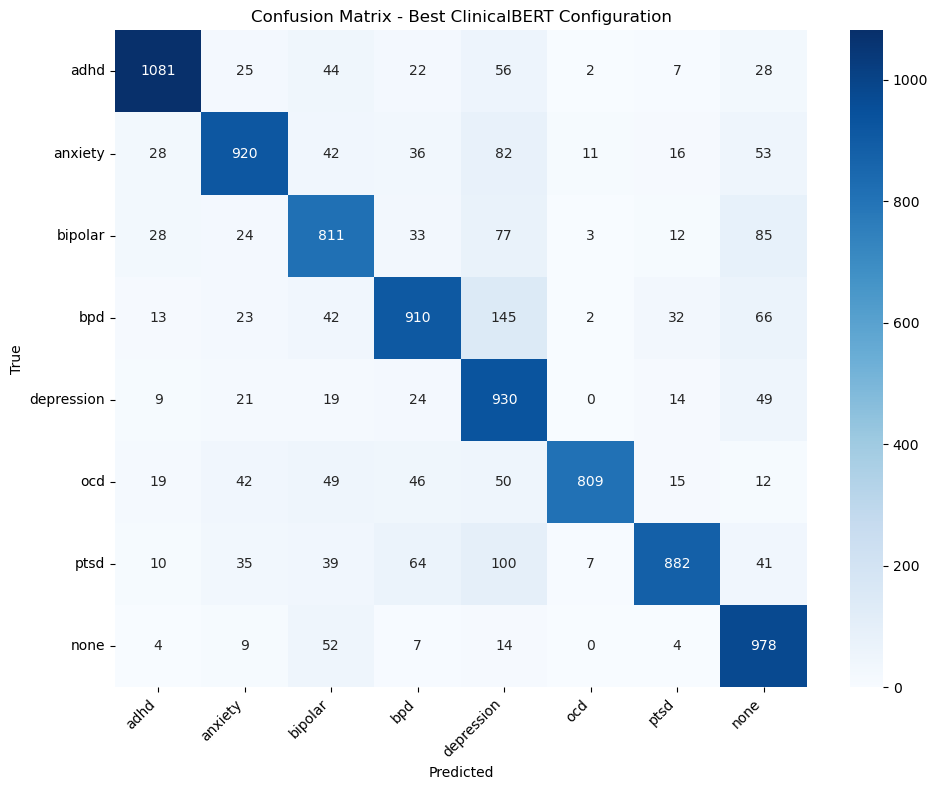

In [20]:
# ClinicalBERT Confusion Matrix
cm_clinicalbert = confusion_matrix(best_clinicalbert_labels, best_clinicalbert_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_clinicalbert, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix - Best ClinicalBERT Configuration")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [21]:
# ClinicalBERT Classification Report
print("\nClassification Report for Best ClinicalBERT Configuration:")
print(classification_report(best_clinicalbert_labels, best_clinicalbert_preds, target_names=label_names, digits=3))


Classification Report for Best ClinicalBERT Configuration:
              precision    recall  f1-score   support

        adhd      0.907     0.855     0.880      1265
     anxiety      0.837     0.774     0.805      1188
     bipolar      0.739     0.756     0.747      1073
         bpd      0.797     0.738     0.766      1233
  depression      0.640     0.872     0.738      1066
         ocd      0.970     0.776     0.862      1042
        ptsd      0.898     0.749     0.817      1178
        none      0.745     0.916     0.822      1068

    accuracy                          0.803      9113
   macro avg      0.817     0.805     0.805      9113
weighted avg      0.819     0.803     0.806      9113



## MedBERT Model Training

In [22]:
# MedBERT Training
print("\n=== Training MedBERT Model ===")
medbert_results = []
for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"\nTraining MedBERT - Batch Size: {batch_size}, Learning Rate: {lr}")
        train_loader = DataLoader(medbert_train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(medbert_val_dataset, batch_size=batch_size)
        
        model = AutoModelForSequenceClassification.from_pretrained('Charangan/MedBERT', num_labels=8)
        trained_model, duration = train_model(model, train_loader, val_loader, lr)
        acc, precision, recall, f1, preds, labels = evaluate_model(trained_model, val_loader)
        
        medbert_results.append({
            "Batch Size": batch_size,
            "Learning Rate": lr,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Duration (min)": duration,
            "Preds": preds,
            "Labels": labels
        })


=== Training MedBERT Model ===

Training MedBERT - Batch Size: 8, Learning Rate: 1e-05


config.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Charangan/MedBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training:   0%|          | 10/2658 [00:01<04:36,  9.58it/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch 1/3 - Training: 100%|██████████| 2658/2658 [04:46<00:00,  9.28it/s]


Epoch 1 - Avg Train Loss: 1.3204
Epoch 1 - Val Loss: 0.7634, Val Accuracy: 0.7603


Epoch 2/3 - Training: 100%|██████████| 2658/2658 [04:46<00:00,  9.26it/s]


Epoch 2 - Avg Train Loss: 0.6816
Epoch 2 - Val Loss: 0.7108, Val Accuracy: 0.7686


Epoch 3/3 - Training: 100%|██████████| 2658/2658 [04:47<00:00,  9.26it/s]


Epoch 3 - Avg Train Loss: 0.5550
Epoch 3 - Val Loss: 0.6325, Val Accuracy: 0.8038

Training MedBERT - Batch Size: 8, Learning Rate: 2e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Charangan/MedBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 2658/2658 [04:47<00:00,  9.25it/s]


Epoch 1 - Avg Train Loss: 1.0570
Epoch 1 - Val Loss: 0.6872, Val Accuracy: 0.7791


Epoch 2/3 - Training: 100%|██████████| 2658/2658 [04:47<00:00,  9.25it/s]


Epoch 2 - Avg Train Loss: 0.6203
Epoch 2 - Val Loss: 0.6616, Val Accuracy: 0.7857


Epoch 3/3 - Training: 100%|██████████| 2658/2658 [04:47<00:00,  9.25it/s]


Epoch 3 - Avg Train Loss: 0.4822
Epoch 3 - Val Loss: 0.6403, Val Accuracy: 0.7922

Training MedBERT - Batch Size: 8, Learning Rate: 3e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Charangan/MedBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 2658/2658 [04:47<00:00,  9.25it/s]


Epoch 1 - Avg Train Loss: 0.9717
Epoch 1 - Val Loss: 0.6873, Val Accuracy: 0.7767


Epoch 2/3 - Training: 100%|██████████| 2658/2658 [04:46<00:00,  9.26it/s]


Epoch 2 - Avg Train Loss: 0.6020
Epoch 2 - Val Loss: 0.6654, Val Accuracy: 0.7905


Epoch 3/3 - Training: 100%|██████████| 2658/2658 [04:46<00:00,  9.27it/s]


Epoch 3 - Avg Train Loss: 0.4856
Epoch 3 - Val Loss: 0.6515, Val Accuracy: 0.7967

Training MedBERT - Batch Size: 16, Learning Rate: 1e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Charangan/MedBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 1329/1329 [04:24<00:00,  5.03it/s]


Epoch 1 - Avg Train Loss: 1.4036
Epoch 1 - Val Loss: 0.8459, Val Accuracy: 0.7293


Epoch 2/3 - Training: 100%|██████████| 1329/1329 [04:24<00:00,  5.03it/s]


Epoch 2 - Avg Train Loss: 0.7271
Epoch 2 - Val Loss: 0.6755, Val Accuracy: 0.7805


Epoch 3/3 - Training: 100%|██████████| 1329/1329 [04:24<00:00,  5.03it/s]


Epoch 3 - Avg Train Loss: 0.5923
Epoch 3 - Val Loss: 0.6471, Val Accuracy: 0.7883

Training MedBERT - Batch Size: 16, Learning Rate: 2e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Charangan/MedBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 1329/1329 [04:23<00:00,  5.03it/s]


Epoch 1 - Avg Train Loss: 1.1927
Epoch 1 - Val Loss: 0.7160, Val Accuracy: 0.7693


Epoch 2/3 - Training: 100%|██████████| 1329/1329 [04:24<00:00,  5.03it/s]


Epoch 2 - Avg Train Loss: 0.6437
Epoch 2 - Val Loss: 0.6685, Val Accuracy: 0.7839


Epoch 3/3 - Training: 100%|██████████| 1329/1329 [04:24<00:00,  5.03it/s]


Epoch 3 - Avg Train Loss: 0.5203
Epoch 3 - Val Loss: 0.6279, Val Accuracy: 0.8045

Training MedBERT - Batch Size: 16, Learning Rate: 3e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Charangan/MedBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 1329/1329 [04:24<00:00,  5.02it/s]


Epoch 1 - Avg Train Loss: 1.0592
Epoch 1 - Val Loss: 0.7127, Val Accuracy: 0.7689


Epoch 2/3 - Training: 100%|██████████| 1329/1329 [04:24<00:00,  5.02it/s]


Epoch 2 - Avg Train Loss: 0.6210
Epoch 2 - Val Loss: 0.6459, Val Accuracy: 0.7861


Epoch 3/3 - Training: 100%|██████████| 1329/1329 [04:24<00:00,  5.02it/s]


Epoch 3 - Avg Train Loss: 0.4893
Epoch 3 - Val Loss: 0.6198, Val Accuracy: 0.8039

Training MedBERT - Batch Size: 32, Learning Rate: 1e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Charangan/MedBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.63it/s]


Epoch 1 - Avg Train Loss: 1.6627
Epoch 1 - Val Loss: 0.9786, Val Accuracy: 0.7013


Epoch 2/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.63it/s]


Epoch 2 - Avg Train Loss: 0.8113
Epoch 2 - Val Loss: 0.7481, Val Accuracy: 0.7581


Epoch 3/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.64it/s]


Epoch 3 - Avg Train Loss: 0.6558
Epoch 3 - Val Loss: 0.6656, Val Accuracy: 0.7862

Training MedBERT - Batch Size: 32, Learning Rate: 2e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Charangan/MedBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.64it/s]


Epoch 1 - Avg Train Loss: 1.3671
Epoch 1 - Val Loss: 0.8284, Val Accuracy: 0.7261


Epoch 2/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.64it/s]


Epoch 2 - Avg Train Loss: 0.6973
Epoch 2 - Val Loss: 0.6829, Val Accuracy: 0.7739


Epoch 3/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.64it/s]


Epoch 3 - Avg Train Loss: 0.5675
Epoch 3 - Val Loss: 0.6211, Val Accuracy: 0.8023

Training MedBERT - Batch Size: 32, Learning Rate: 3e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Charangan/MedBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.64it/s]


Epoch 1 - Avg Train Loss: 1.2102
Epoch 1 - Val Loss: 0.7305, Val Accuracy: 0.7599


Epoch 2/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.64it/s]


Epoch 2 - Avg Train Loss: 0.6457
Epoch 2 - Val Loss: 0.6566, Val Accuracy: 0.7867


Epoch 3/3 - Training: 100%|██████████| 665/665 [04:12<00:00,  2.64it/s]


Epoch 3 - Avg Train Loss: 0.5060
Epoch 3 - Val Loss: 0.6001, Val Accuracy: 0.8066


In [23]:
# MedBERT Results
medbert_df = pd.DataFrame(medbert_results).drop(columns=["Preds", "Labels"])
print("\nMedBERT Results Summary:")
medbert_df


MedBERT Results Summary:


,Batch Size,Learning Rate,Accuracy,Precision,Recall,F1,Duration (min)
0,8,0.00001,0.803797,0.814612,0.803797,0.805171,16.194829
1,8,0.00002,0.792165,0.807087,0.792165,0.794212,16.218992
2,8,0.00003,0.796664,0.804803,0.796664,0.796004,16.201681
3,16,0.00001,0.788324,0.793718,0.788324,0.788634,14.887936
4,16,0.00002,0.804455,0.820168,0.804455,0.806658,14.890983
5,16,0.00003,0.803907,0.805154,0.803907,0.803732,14.920415
6,32,0.00001,0.786239,0.791996,0.786239,0.786724,14.282263
7,32,0.00002,0.802261,0.805433,0.802261,0.802550,14.276122
8,32,0.00003,0.806650,0.812313,0.806650,0.807532,14.271182


In [24]:
# Best MedBERT Configuration
best_medbert_config = medbert_df.loc[medbert_df["F1"].idxmax()]
print(f"\nBest MedBERT Configuration: Batch Size {best_medbert_config['Batch Size']}, Learning Rate {best_medbert_config['Learning Rate']}")
print(f"Accuracy: {best_medbert_config['Accuracy']:.4f}, Precision: {best_medbert_config['Precision']:.4f}, Recall: {best_medbert_config['Recall']:.4f}, F1: {best_medbert_config['F1']:.4f}")


Best MedBERT Configuration: Batch Size 32.0, Learning Rate 3e-05
Accuracy: 0.8066, Precision: 0.8123, Recall: 0.8066, F1: 0.8075


In [25]:
best_medbert_idx = medbert_df["F1"].idxmax()
best_medbert_preds = medbert_results[best_medbert_idx]["Preds"]
best_medbert_labels = medbert_results[best_medbert_idx]["Labels"]

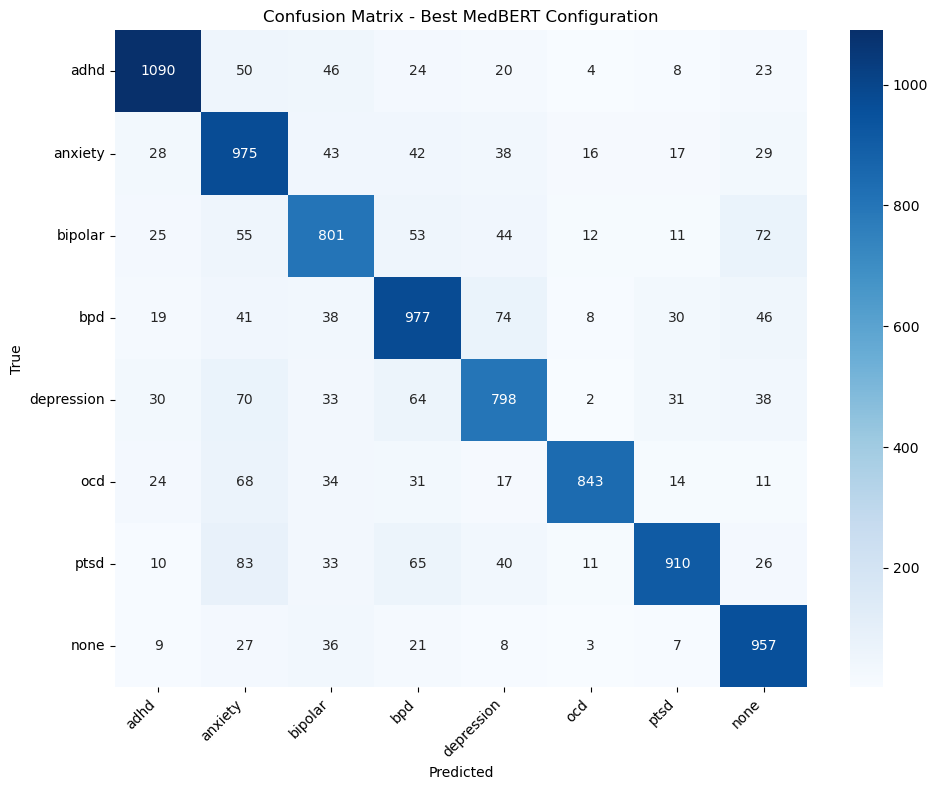

In [26]:
# MedBERT Confusion Matrix
cm_medbert = confusion_matrix(best_medbert_labels, best_medbert_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_medbert, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix - Best MedBERT Configuration")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [27]:
# MedBERT Classification Report
print("\nClassification Report for Best MedBERT Configuration:")
print(classification_report(best_medbert_labels, best_medbert_preds, target_names=label_names, digits=3))


Classification Report for Best MedBERT Configuration:
              precision    recall  f1-score   support

        adhd      0.883     0.862     0.872      1265
     anxiety      0.712     0.821     0.763      1188
     bipolar      0.753     0.747     0.750      1073
         bpd      0.765     0.792     0.778      1233
  depression      0.768     0.749     0.758      1066
         ocd      0.938     0.809     0.869      1042
        ptsd      0.885     0.772     0.825      1178
        none      0.796     0.896     0.843      1068

    accuracy                          0.807      9113
   macro avg      0.812     0.806     0.807      9113
weighted avg      0.812     0.807     0.808      9113

